# Training (Model)

This workflow hyperparam optimizes
    - nBits
    - nFeatures

In [3]:
from functools import partial
from rdkit import Chem

import matplotlib.pyplot as plt
import pickle as pk
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from polyml import MultiModel

from mordred import MolecularDistanceEdge, get_descriptors_in_module, descriptors, Calculator
import mordred

def mae(a1, a2):
    return np.mean(np.abs(a1-a2))

def rmse(a1, a2):
    return np.sqrt(np.mean((a1-a2)**2))

import time

import multiprocessing as mp

from RF_utils import calc_mordred_df

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Load in MultiModel of Message Passing

In [4]:
mm_fpath = "../../stereochem_predictive_model/220504_af64_bf64_mf8_mg10_DP25_R5_K10_global_pm/220414_stereo_polymers_MW_DP25_R5_K10_multimodel.pk"
mm = MultiModel().load_training_data(mm_fpath)
df = mm.df_input

# Generate/Load in Descriptors

## Mordred

### Generate Mordred Descriptors First Time
Uncomment to calculate

In [4]:
# t = time.time()
# descriptor_list = [i for i in get_descriptors_in_module(descriptors) if i not in [MolecularDistanceEdge.MolecularDistanceEdge]]
# calc = Calculator(descriptor_list, ignore_3D=True)
# df_mord = calc.pandas(list(df.mol.values))
# df_mord.to_csv("df_mord.csv", index=False)
# print(time.time() - t)

### Load Mordred Descriptors

In [5]:
df_mord = pd.read_csv("./descriptors/df_mord.csv")
bad_cols = df_mord.columns[df_mord.applymap(lambda x: not (isinstance(x, float) or isinstance(x, int))).any()] 
df_mord = df_mord.drop(columns=bad_cols)

/var/folders/mn/k32kn37x5ldgpp51c6cdmkpm0000gn/T/ipykernel_9944/3693373612.py:1: DtypeWarning: Columns (233,234,235,236,237,238,239,240,241,341,342,343,344,345,346,347,348,349,449,450,451,452,453,454,455,456,545,546,547,548,549,550,551,552,641,642,780,781,1055,1057,1061,1064,1082,1083,1084,1134,1136,1140,1143,1161,1162,1163) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mord = pd.read_csv("./descriptors/df_mord.csv")


## Fingerprints

In [6]:
def gen_fingerprint_df(df_input, nbits=2048, nBitsPerHash=1, radius=2, fp_type="rdkit"):
    def f(fps):
        return pd.Series([int(i) for i in fps.ToBitString()])

    df_input = df_input.copy()
    
    if "mol" not in df_input:
        df_input['mol'] = df_input['smiles_polymer'].map(Chem.MolFromSmiles)

    if fp_type == "rdkit":
        fps_partial = partial(Chem.RDKFingerprint, fpSize=nbits, nBitsPerHash=nBitsPerHash)
    elif fp_type == "morgan":
        fps_partial = partial(AllChem.GetMorganFingerprintAsBitVect, radius=radius, nBits=nbits)
    else:
        assert False, "Bad Fingerprint Type"
        
    df_input.loc[:, "fingerprints"] = df_input["mol"].map(fps_partial)

    list_of_bits = []

    df_input = df_input.reset_index(drop=True)
    for i, row in df_input.iterrows():
        list_of_bits.append(f(row.fingerprints))

    df_bits = pd.DataFrame(data=list_of_bits, columns=range(nbits))

    return pd.concat([df_input, df_bits], axis=1)

In [ ]:
# rad=2
# fp_type="rdkit"

# for nbits in [16, 32, 64, 128]: #[256, 512, 1024, 2048]:
#     df_fps = gen_fingerprint_df(df, nbits=nbits)
#     df_fps.to_csv(f"./descriptors/df_fp_nbits{nbits}_rad{rad}_type{fp_type}")


KeyboardInterrupt



# Hyperparam optimize with all data on OOB performance

## Visualize Feature Importance

In [7]:
# Get FP Features
nbits=64
df_fps = pd.read_csv("./descriptors/fp_nbits_rad2_typerdkit/df_fp_nbits512_rad2_typerdkit")
df_features = pd.concat([df_fps.loc[:, [str(i) for i in range(0, nbits)]], df_mord], axis=1)

# Train Example Model
model = RandomForestRegressor(
    n_estimators=200,
    random_state=2,
    oob_score=True
)

X_train = df_features
y_train = df["Tm"].to_frame()

X_train = X_train[~y_train.Tm.isna()]
y_train = y_train[~y_train.Tm.isna()]

X_train = X_train.drop(columns=X_train.columns[[X_train.isna().any()]])

# Scale X_train
ss_X = StandardScaler()
ss_Y = StandardScaler()

X_cols = X_train.columns
y_cols = y_train.columns

X_train = pd.DataFrame(ss_X.fit_transform(X_train), columns=X_cols)
y_train = pd.DataFrame(ss_Y.fit_transform(y_train), columns=y_cols)

model.fit(X_train, y_train)
model.oob_score_

/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/var/folders/mn/k32kn37x5ldgpp51c6cdmkpm0000gn/T/ipykernel_9944/1665957411.py:31: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


0.8604288259595605

In [8]:
feature_importances = [*zip(X_train.columns, model.feature_importances_)]
feature_importances.sort(key=lambda x: x[1], reverse=True)

df_feat_imp = pd.DataFrame(feature_importances, columns=["Feature", "Importance"])

# top_n = 20
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# sns.barplot(x="Feature", y="Importance", data=df_feat_imp.loc[:100, :], ax=ax)
# plt.xticks(rotation = 45);

# Load Existing Data

# Train Models

## T_g

In [14]:
# mm_fpath = "../2200504_af64_bf64_mf8_mg10_DP25_R5_K10_global_pm/220414_stereo_polymers_MW_DP25_R5_K10_multimodel.pk"
# mm_fpath = "../data/220414_stereo_polymers_MW_DP25_R5_K10_multimodel.pk"
mm = MultiModel().load_training_data(mm_fpath)

In [20]:
nbits=64
n_estimators=100
min_samples_leaf=20
top_n_features=10
max_depth=10
random_state=0

# Fit Tg
nbits=512
df_fps = pd.read_csv("./descriptors/fp_nbits_rad2_typerdkit/df_fp_nbits512_rad2_typerdkit")

df_features = pd.concat([df_fps.loc[:, [str(i) for i in range(0, nbits)]], df_mord, mm.df_input.loc[:, ["smiles_polymer"]]], axis=1)

df_tg_train = pd.DataFrame()

tg_models = [GradientBoostingRegressor(n_estimators=n_estimators, max_depth=5, min_samples_leaf=min_samples_leaf, random_state=random_state) for i in range(len(mm.models))]
tg_scalers = [{"x": StandardScaler(), "y": StandardScaler()} for i in range(len(mm.models))]
# top_features = ['AXp-5d', 'MATS4d', 'GATS4p', 'AATS6se', 'GATS3s', 'SIC0', 'ATS1p', 'GATS5pe', 'JGI2']
top_features = [*df_feat_imp.loc[:top_n_features, "Feature"]]

df_features = pd.concat([df_fps.loc[:, [str(i) for i in range(0, nbits)]], df_mord, mm.df_input.loc[:, ["smiles_polymer"]]], axis=1)     
df_tg_train = pd.DataFrame()
for mi, model in enumerate(tg_models):
    print(mi)
    df_train = mm.models[mi].df_train.copy()
    df_train = df_train[~df_train["Tg"].isna()]

    y_train = df_train["Tg"].to_frame()
    X_train = pd.DataFrame(columns = top_features)

    for _, row in df_train.iterrows():
        X_train = pd.concat([X_train, df_features.loc[df_features["smiles_polymer"] == row.smiles_polymer, top_features].iloc[0, :].to_frame().T])

    X_train = X_train.loc[:, top_features].reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_train = X_train[~y_train.Tg.isna()]
    y_train = y_train[~y_train.Tg.isna()]
    ###
    ###
    ###
    # TODO this could be bad when testing, if top_features changes
    ###
    ###
    ###
    X_train = X_train.drop(columns=X_train.columns[[X_train.isna().any()]])

    # X_cols = X_train.columns
    # y_cols = y_train.columns
    X_train = tg_scalers[mi]["x"].fit_transform(X_train)
    y_train = tg_scalers[mi]["y"].fit_transform(y_train)
    # X_train = pd.DataFrame(X_train, columns=X_cols)
    # y_train = pd.DataFrame(y_train, columns=y_cols)

    model.fit(X_train, np.ravel(y_train))
    y_pred = model.predict(X_train)

    df = pd.DataFrame(
        zip([i[0] for i in tg_scalers[mi]["y"].inverse_transform(y_train)], [i[0] for i in tg_scalers[mi]["y"].inverse_transform(y_pred.reshape(-1, 1))]),
        columns=["Tg", "Tg_pred"]
    )

    df["model_id"] = str(mi)
    df_tg_train = pd.concat([df_tg_train, df])

# Predict on validate
df_tg_preds = pd.DataFrame()
for mi, model in enumerate(tg_models):
    df_val = mm.models[mi].df_validate.copy()
    df_val = df_val[~df_val["Tg"].isna()]

    y_val = df_val["Tg"].to_frame()
    X_val = pd.DataFrame(columns = top_features)

    for _, row in df_val.iterrows():
        X_val = pd.concat([X_val, df_features.loc[df_features["smiles_polymer"] == row.smiles_polymer, top_features].iloc[0, :].to_frame().T])

    X_val = X_val.loc[:, top_features].reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)

#     X_cols = X_val.columns
#     y_cols = y_val.columns
    X_val = tg_scalers[mi]["x"].transform(X_val)
    y_val = tg_scalers[mi]["y"].transform(y_val)
    # X_val = pd.DataFrame(X_val, columns=X_cols)
    # y_val = pd.DataFrame(y_val, columns=y_cols)

    y_pred =[i[0] for i in tg_scalers[mi]["y"].inverse_transform(model.predict(X_val).reshape(-1, 1))]
    y_val = [i[0] for i in tg_scalers[mi]["y"].inverse_transform(y_val.reshape(-1, 1))]

    df = pd.DataFrame(zip(y_val, y_pred), columns=["Tg", "Tg_pred"])
    df["model_id"] = str(mi)

    df_tg_preds = pd.concat([df_tg_preds, df])

pred_col = "Tg"
df_to_calc = df_tg_preds
mae_pred = np.mean(np.abs((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values)))
rmse_pred = np.sqrt(np.mean((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values)**2))
r2_pred = r2_score(df_to_calc[pred_col].values, df_to_calc[f"{pred_col}_pred"].values)

df_to_calc = df_tg_train
rmse_train = np.sqrt(np.mean((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values)**2))
mae_train = np.mean(np.abs((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values)))
r2_train = r2_score(df_to_calc[pred_col].values, df_to_calc[f"{pred_col}_pred"].values)

0


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


1


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


2


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


3


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


4


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


5


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


6


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


7


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


8


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


9


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [22]:
from sklearn.metrics import r2_score
pred_col = "Tg"
df_to_calc = df_tg_preds
print("Val Prediction for: ", pred_col)
print("\tR^2: ", r2_score(df_to_calc[pred_col].values, df_to_calc[f"{pred_col}_pred"].values))
print("\tmae:", np.mean(np.abs((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values))))
print("\trmse:",np.sqrt(np.mean((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values)**2)))

df_to_calc = df_tg_train
print("Train Prediction for: ", pred_col)
print("\tR^2: ", r2_score(df_to_calc[pred_col].values, df_to_calc[f"{pred_col}_pred"].values))
print("\tmae:", np.mean(np.abs((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values))))
print("\trmse:",np.sqrt(np.mean((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values)**2)))

Val Prediction for:  Tg
	R^2:  0.8458054551010181
	mae: 11.536181798010409
	rmse: 21.521182684838124
Train Prediction for:  Tg
	R^2:  0.9298084358614552
	mae: 7.588165935693641
	rmse: 14.520249853977203


## T_m

In [14]:
# Fit Tm
nbits=64
n_estimators=100
min_samples_leaf=20
top_n_features=10
max_depth=10
random_state=0

# Fit Tg
nbits=512
df_fps = pd.read_csv("./descriptors/fp_nbits_rad2_typerdkit/df_fp_nbits512_rad2_typerdkit")

tm_models = [GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=random_state) for i in range(len(mm.models))]
df_features = pd.concat([df_fps.loc[:, [str(i) for i in range(0, nbits)]], df_mord, mm.df_input.loc[:, ["smiles_polymer"]]], axis=1)
tm_scalers = [{"x": StandardScaler(), "y": StandardScaler()} for i in range(len(mm.models))]
# top_features = ['AXp-5d', 'MATS4d', 'GATS4p', 'AATS6se', 'GATS3s', 'SIC0', 'ATS1p', 'GATS5pe', 'JGI2']
top_features = [*df_feat_imp.loc[:top_n_features, "Feature"]]

df_tm_train = pd.DataFrame()
for mi, model in enumerate(tm_models):
    print(mi)
    df_train = mm.models[mi].df_train.copy()
    df_train = df_train[~df_train["Tm"].isna()]

    y_train = df_train["Tm"].to_frame()
    X_train = pd.DataFrame(columns = top_features)

    for _, row in df_train.iterrows():
        X_train = pd.concat([X_train, df_features.loc[df_features["smiles_polymer"] == row.smiles_polymer, top_features].iloc[0, :].to_frame().T])

    X_train = X_train.loc[:, top_features].reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_train = X_train[~y_train.Tm.isna()]
    y_train = y_train[~y_train.Tm.isna()]
    ###
    ###
    ###
    # TODO this could be bad when testing, if top_features changes
    ###
    ###
    ###
    X_train = X_train.drop(columns=X_train.columns[[X_train.isna().any()]])

    # X_cols = X_train.columns
    # y_cols = y_train.columns
    X_train = tm_scalers[mi]["x"].fit_transform(X_train)
    y_train = tm_scalers[mi]["y"].fit_transform(y_train)
    # X_train = pd.DataFrame(X_train, columns=X_cols)
    # y_train = pd.DataFrame(y_train, columns=y_cols)

    model.fit(X_train, np.ravel(y_train))
    y_pred = model.predict(X_train)

    df = pd.DataFrame(
        zip([i[0] for i in tm_scalers[mi]["y"].inverse_transform(y_train)], [i[0] for i in tm_scalers[mi]["y"].inverse_transform(y_pred.reshape(-1, 1))]),
        columns=["Tm", "Tm_pred"]
    )

    df["model_id"] = str(mi)
    df_tm_train = pd.concat([df_tm_train, df])

# Predict on validate
df_tm_preds = pd.DataFrame()
for mi, model in enumerate(tm_models):
    df_val = mm.models[mi].df_validate.copy()
    df_val = df_val[~df_val["Tm"].isna()]

    y_val = df_val["Tm"].to_frame()
    X_val = pd.DataFrame(columns = top_features)

    for _, row in df_val.iterrows():
        X_val = pd.concat([X_val, df_features.loc[df_features["smiles_polymer"] == row.smiles_polymer, top_features].iloc[0, :].to_frame().T])

    X_val = X_val.loc[:, top_features].reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)

#     X_cols = X_val.columns
#     y_cols = y_val.columns
    X_val = tm_scalers[mi]["x"].transform(X_val)
    y_val = tm_scalers[mi]["y"].transform(y_val)
    # X_val = pd.DataFrame(X_val, columns=X_cols)
    # y_val = pd.DataFrame(y_val, columns=y_cols)

    y_pred = [i[0] for i in tm_scalers[mi]["y"].inverse_transform(model.predict(X_val).reshape(-1, 1))]
    y_val = [i[0] for i in tm_scalers[mi]["y"].inverse_transform(y_val.reshape(-1, 1))]

    df = pd.DataFrame(zip(y_val, y_pred), columns=["Tm", "Tm_pred"])
    df["model_id"] = str(mi)

    df_tm_preds = pd.concat([df_tm_preds, df])

pred_col = "Tm"
df_to_calc = df_tm_preds
mae_pred = np.mean(np.abs((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values)))
rmse_pred = np.sqrt(np.mean((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values)**2))
r2_pred = r2_score(df_to_calc[pred_col].values, df_to_calc[f"{pred_col}_pred"].values)

df_to_calc = df_tm_train
rmse_train = np.sqrt(np.mean((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values)**2))
mae_train = np.mean(np.abs((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values)))
r2_train = r2_score(df_to_calc[pred_col].values, df_to_calc[f"{pred_col}_pred"].values)

0


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


1


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


2


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


3


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


4


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


5


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


6


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


7


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


8


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


9


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [19]:
from sklearn.metrics import r2_score
pred_col = "Tm"
df_to_calc = df_tm_preds
print("Val Prediction for: ", pred_col)
print("\tR^2: ", r2_score(df_to_calc[pred_col].values, df_to_calc[f"{pred_col}_pred"].values))
print("\tmae:", np.mean(np.abs((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values))))
print("\trmse:",np.sqrt(np.mean((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values)**2)))

df_to_calc = df_tm_train
print("Train Prediction for: ", pred_col)
print("\tR^2: ", r2_score(df_to_calc[pred_col].values, df_to_calc[f"{pred_col}_pred"].values))
print("\tmae:", np.mean(np.abs((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values))))
print("\trmse:",np.sqrt(np.mean((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values)**2)))

Val Prediction for:  Tm
	R^2:  0.7570480766595671
	mae: 21.32345130700211
	rmse: 34.200178551986816
Train Prediction for:  Tm
	R^2:  0.8766639541700949
	mae: 14.105110301573726
	rmse: 24.36762558799539


In [23]:
# Join together results
df_results = pd.concat([df_tg_preds, df_tm_preds])
df_results["model"] = "RF_nopm"

df_results["Tg_MAE"] = abs(df_results["Tg"] - df_results["Tg_pred"])
df_results["Tm_MAE"] = abs(df_results["Tm"] - df_results["Tm_pred"])
df_results.groupby(by=["model", "model_id"]).aggregate("mean").reset_index().drop(columns=["Tg", "Tg_pred", "Tm", "Tm_pred"])
df_results.to_csv("RF_results/MAE_RF_nopm_results.csv")

# Package Models Into Class

In [31]:
class GB_nopm_Predictors:
    def __init__(self):
        self.tg_models = None
        self.tg_scalers = None
        self.tm_models = None
        self.tm_scalers = None
        self.df_features = None
        self.top_features = ['AXp-5d', 'MATS4d', 'GATS4p', 'AATS6se', 'GATS3s', 'SIC0', 'ATS1p', 'GATS5pe', 'JGI2']

        self.mordred_descriptors = [
            mordred.Chi.Chi("path", 5, "d", True),
            mordred.Autocorrelation.MATS(4, "d"),
            mordred.Autocorrelation.GATS(4, "p"),
            mordred.Autocorrelation.GATS(4, "s"),
            mordred.InformationContent.StructuralIC(0),
            mordred.Autocorrelation.AATS(6, "se"),
            mordred.Autocorrelation.GATS(3, "s"),
            mordred.Autocorrelation.ATS(1, "p"),
            mordred.Autocorrelation.GATS(5, "pe"),
            mordred.TopologicalCharge.TopologicalCharge('mean', 2)
        ]
        self.MordCalc = Calculator(self.mordred_descriptors, ignore_3D=True)
        
    def gen_feature_df(self, df_polymer):
        df_polymer["mol"] = df_polymer.smiles_polymer.apply(Chem.MolFromSmiles)
        df_mord = self.MordCalc.pandas(list(df_polymer.mol.values))
        # This iteration doesn't include any fingerprints, so ignored here
        df_mord.index = df_polymer.index
        self.df_features = pd.concat([df_polymer, df_mord], axis=1).reset_index(drop=True)
    
    def predict_Tm(self, df_polymer):
        df_tm_preds = pd.DataFrame()
        for mi, model in enumerate(self.tm_models):
            print(mi)
            df_val = df_polymer.copy()
            X_val = pd.DataFrame(columns = self.top_features)

            for _, row in df_val.iterrows():
                X_val = pd.concat([X_val, self.df_features.loc[self.df_features["smiles_polymer"] == row.smiles_polymer, self.top_features].iloc[0, :].to_frame().T])

            X_val = X_val.loc[:, self.top_features].reset_index(drop=True)
            X_val = self.tm_scalers[mi]["x"].transform(X_val)
            y_pred = [i[0] for i in self.tm_scalers[mi]["y"].inverse_transform(model.predict(X_val).reshape(-1, 1))]

            df = pd.DataFrame(y_pred, columns=["Tm_pred"], index=df_polymer.index)
            df["model_id"] = str(mi)
            df = pd.concat([df_polymer, df], axis=1)

            df_tm_preds = pd.concat([df_tm_preds, df])
            
        return df_tm_preds
    
    def predict_Tg(self, df_polymer):
        df_tm_preds = pd.DataFrame()
        for mi, model in enumerate(self.tg_models):
            print(mi)
            df_val = df_polymer.copy()
            X_val = pd.DataFrame(columns = self.top_features)

            for _, row in df_val.iterrows():
                X_val = pd.concat([X_val, self.df_features.loc[self.df_features["smiles_polymer"] == row.smiles_polymer, self.top_features].iloc[0, :].to_frame().T])

            X_val = X_val.loc[:, self.top_features].reset_index(drop=True)
            X_val = self.tm_scalers[mi]["x"].transform(X_val)
            y_pred = [i[0] for i in self.tg_scalers[mi]["y"].inverse_transform(model.predict(X_val).reshape(-1, 1))]

            df = pd.DataFrame(y_pred, columns=["Tg_pred"], index=df_polymer.index)
            df["model_id"] = str(mi)
            df = pd.concat([df_polymer, df], axis=1)

            df_tm_preds = pd.concat([df_tm_preds, df])
            
        return df_tm_preds
    
    def predict(self, df_polymer):
        df_tg = self.predict_Tg(df_polymer)
        df_tm = self.predict_Tm(df_polymer)
        
        return pd.concat([df_tg, df_tm["Tm_pred"]], axis=1)


In [33]:
preds = GB_nopm_Predictors()

# preds.df_mord = df_mord
preds.tg_models = tg_models
preds.tg_scalers = tg_scalers
preds.tm_models = tm_models
preds.tm_scalers = tm_scalers
preds.df_features = df_features

to_pickle = {
    "source_data": mm.df_input,
    "model": preds
}

with open("./models/GB_nopm.pk", "wb") as f:
    pk.dump(to_pickle, f)

In [35]:
# Test depickle
model_dict = pk.load(open("./models/GB_nopm.pk", "rb") )
model = model_dict["model"]

df_polymer = mm.df_input#[~mm.df_input.duplicated("smiles_monomer")]
model.gen_feature_df(df_polymer)
df_pred = model.predict(df_polymer)

  4%|███▍                                                                                           | 115/3195 [00:14<06:35,  7.79it/s]


KeyboardInterrupt: 

In [118]:
df_pred_agg = df_pred.groupby(by=["smiles_monomer", "distribution", "pm"]).agg("mean").reset_index()

<AxesSubplot:xlabel='Tm', ylabel='Tm_pred'>

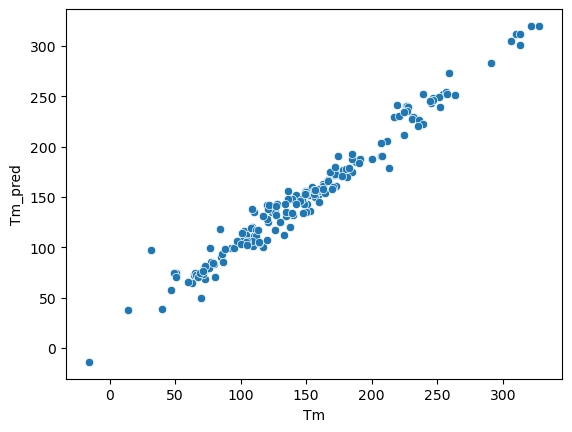

In [119]:
sns.scatterplot(x="Tm", y="Tm_pred", data=df_pred_agg)

# Hyperparam Otpimize

## Glass Transition
### nbits does not matter
top_n_features = [10, 30, 50]
n_estimators = [100, 300, 600 1000]
min_samples_leaf = [1, 5, 10, 20]
max_depth = [1, 5, 10, 20]

In [9]:
top_n_features_list = [10, 50]
n_estimators_list = [100, 200]
min_samples_leaf_list = [10, 30]
max_depth_list = [20]
res_list = []
i = 0
random_state = 0
nbits=32
df_fps = pd.read_csv(f"./descriptors/fp_nbits_rad2_typerdkit/df_fp_nbits{32}_rad2_typerdkit")
for top_n_features in top_n_features_list:
    for n_estimators in n_estimators_list:
        for min_samp in min_samples_leaf_list:
            for max_depth in max_depth_list:
                i += 1
                print(f"{i}\nn feat{top_n_features}\nn est {n_estimators}\nmin samp {min_samp}\nmax depth {max_depth}")
                
                top_features = [*df_feat_imp.loc[:top_n_features, "Feature"]]
                tg_models = [RandomForestRegressor(n_estimators=n_estimators, min_samples_leaf=min_samp, max_depth=max_depth) for i in range(len(mm.models))] #, random_state=random_state, max_depth=max_depth, min_samples_leaf=min_samp
                scalers = [{"x": StandardScaler(), "y": StandardScaler()} for i in range(len(mm.models))]
                
                # Fit tg
                df_features = pd.concat([df_fps.loc[:, [str(i) for i in range(0, nbits)]], df_mord, mm.df_input.loc[:, ["smiles_polymer"]]], axis=1)
                
                df_tg_train = pd.DataFrame()
                for mi, model in enumerate(tg_models):  
                    df_train = mm.models[mi].df_train.copy()
                    df_train = df_train[~df_train["Tg"].isna()]

                    y_train = df_train["Tg"].to_frame()
                    X_train = pd.DataFrame(columns = top_features)

                    for _, row in df_train.iterrows():
                        X_train = pd.concat([X_train, df_features.loc[df_features["smiles_polymer"] == row.smiles_polymer, top_features].iloc[0, :].to_frame().T])

                    X_train = X_train.loc[:, top_features].reset_index(drop=True)
                    y_train = y_train.reset_index(drop=True)
                    X_train = X_train[~y_train.Tg.isna()]
                    y_train = y_train[~y_train.Tg.isna()]
                    ###
                    ###
                    ###
                    # TODO this could be bad when testing, if top_features changes
                    ###
                    ###
                    ###
                    X_train = X_train.drop(columns=X_train.columns[[X_train.isna().any()]])

                    # X_cols = X_train.columns
                    # y_cols = y_train.columns
                    X_train = scalers[mi]["x"].fit_transform(X_train)
                    y_train = scalers[mi]["y"].fit_transform(y_train)
                    # X_train = pd.DataFrame(X_train, columns=X_cols)
                    # y_train = pd.DataFrame(y_train, columns=y_cols)

                    model.fit(X_train, np.ravel(y_train))
                    y_pred = model.predict(X_train)

                    df = pd.DataFrame(
                        zip([i[0] for i in scalers[mi]["y"].inverse_transform(y_train)], [i[0] for i in scalers[mi]["y"].inverse_transform(y_pred.reshape(-1, 1))]),
                        columns=["Tg", "Tg_pred"]
                    )

                    df["model_id"] = str(mi)
                    df_tg_train = pd.concat([df_tg_train, df])

                # Predict on validate
                df_tg_preds = pd.DataFrame()
                for mi, model in enumerate(tg_models):
                    df_val = mm.models[mi].df_validate.copy()
                    df_val = df_val[~df_val["Tg"].isna()]

                    y_val = df_val["Tg"].to_frame()
                    X_val = pd.DataFrame(columns = top_features)

                    for _, row in df_val.iterrows():
                        X_val = pd.concat([X_val, df_features.loc[df_features["smiles_polymer"] == row.smiles_polymer, top_features].iloc[0, :].to_frame().T])

                    X_val = X_val.loc[:, top_features].reset_index(drop=True)
                    y_val = y_val.reset_index(drop=True)

                #     X_cols = X_val.columns
                #     y_cols = y_val.columns
                    X_val = scalers[mi]["x"].transform(X_val)
                    y_val = scalers[mi]["y"].transform(y_val)
                    # X_val = pd.DataFrame(X_val, columns=X_cols)
                    # y_val = pd.DataFrame(y_val, columns=y_cols)

                    y_pred =[i[0] for i in scalers[mi]["y"].inverse_transform(model.predict(X_val).reshape(-1, 1))]
                    y_val = [i[0] for i in scalers[mi]["y"].inverse_transform(y_val.reshape(-1, 1))]

                    df = pd.DataFrame(zip(y_val, y_pred), columns=["Tg", "Tg_pred"])
                    df["model_id"] = str(mi)

                    df_tg_preds = pd.concat([df_tg_preds, df])
                
                pred_col = "Tg"
                df_to_calc = df_tg_preds
                mae_pred = np.mean(np.abs((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values)))
                rmse_pred = np.sqrt(np.mean((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values)**2))
                r2_pred = r2_score(df_to_calc[pred_col].values, df_to_calc[f"{pred_col}_pred"].values)
                
                df_to_calc = df_tg_train
                rmse_train = np.sqrt(np.mean((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values)**2))
                mae_train = np.mean(np.abs((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values)))
                r2_train = r2_score(df_to_calc[pred_col].values, df_to_calc[f"{pred_col}_pred"].values)
                
                res_list += [[top_n_features, n_estimators, min_samp, max_depth, mae_pred, rmse_pred, r2_pred, mae_train, rmse_train, r2_train]]

1
n feat10
n est 100
min samp 10
max depth 20


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead 

2
n feat10
n est 100
min samp 30
max depth 20


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead 

3
n feat10
n est 200
min samp 10
max depth 20


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead 

4
n feat10
n est 200
min samp 30
max depth 20


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead 

5
n feat50
n est 100
min samp 10
max depth 20


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead 

6
n feat50
n est 100
min samp 30
max depth 20


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead 

7
n feat50
n est 200
min samp 10
max depth 20


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead 

8
n feat50
n est 200
min samp 30
max depth 20


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead 

In [11]:
# df_res.to_csv("GB_scans/no_pm/Tg_nopm_max_depth.csv")
df_res

,top_n_features,n_estimators,min_samp,max_depth,mae_pred,rmse_pred,r2_pred,mae_train,rmse_train,r2_train
0,10,100,10,20,12.139026,22.052764,0.838094,8.771703,15.621525,0.918757
1,10,100,30,20,14.667034,24.077044,0.807006,12.122771,19.628002,0.871741
2,10,200,10,20,12.176610,22.112394,0.837217,8.783501,15.626115,0.918710
3,10,200,30,20,14.564023,24.046115,0.807502,12.085872,19.623898,0.871794
4,50,100,10,20,11.441426,21.016165,0.852957,7.977625,14.843873,0.926645
5,50,100,30,20,13.076629,22.113638,0.837199,10.114013,16.858424,0.905383
6,50,200,10,20,11.537457,21.201167,0.850357,7.969193,14.843569,0.926648
7,50,200,30,20,13.147687,22.253563,0.835132,10.122935,16.870428,0.905248


In [10]:
df_res = pd.DataFrame(res_list, columns=["top_n_features", "n_estimators", "min_samp", "max_depth", "mae_pred", "rmse_pred", "r2_pred", "mae_train", "rmse_train", "r2_train"])

In [12]:
df_res = pd.concat([df_res, df_res_7])

[Text(0.5, 0, 'Minimum Sample'), Text(0, 0.5, 'Tg MAE (°C) Validation')]

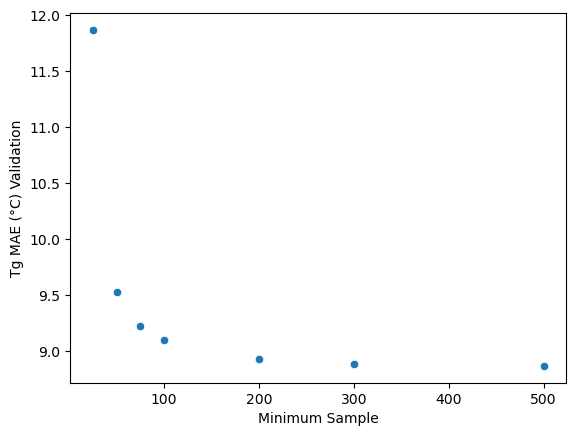

In [59]:
g = sns.scatterplot(x="n_estimators", y="mae_pred", data=df_res)
g.set(
    xlabel="Minimum Sample",
    ylabel="Tg MAE (°C) Validation"
)

In [19]:
df_res.to_csv("GB_scans/Tg_features.csv")

## Tm Hyperparam Optimization

In [20]:
top_n_features_list = [10, 50, 100, 200]
n_estimators_list = [100]
min_samples_leaf_list = [20] #, 2, 5]
max_depth_list = [10]
res_list = []
i = 0
random_state = 0

df_fps = pd.read_csv(f"./descriptors/fp_nbits_rad2_typerdkit/df_fp_nbits{32}_rad2_typerdkit")
for top_n_features in top_n_features_list:
    for n_estimators in n_estimators_list:
        for min_samp in min_samples_leaf_list:
            for max_depth in max_depth_list:
                i += 1
                print(f"{i}\nn feat{top_n_features}\nn est {n_estimators}\nmin samp {min_samp}\nmax depth {max_depth}")
                
                top_features = [*df_feat_imp.loc[:top_n_features, "Feature"]]
                tm_models = [GradientBoostingRegressor(n_estimators=n_estimators, min_samples_leaf=min_samp, max_depth=max_depth) for i in range(len(mm.models))] #, random_state=random_state, max_depth=max_depth, min_samples_leaf=min_samp
                scalers = [{"x": StandardScaler(), "y": StandardScaler()} for i in range(len(mm.models))]
                
                # Fit tm
                df_features = pd.concat([df_fps.loc[:, [str(i) for i in range(0, nbits)]], df_mord, mm.df_input.loc[:, ["pm", "smiles_polymer"]]], axis=1)
                
                df_tm_train = pd.DataFrame()
                for mi, model in enumerate(tm_models):  
                    df_train = mm.models[mi].df_train.copy()
                    df_train = df_train[~df_train["Tm"].isna()]

                    y_train = df_train["Tm"].to_frame()
                    X_train = pd.DataFrame(columns = top_features)

                    for _, row in df_train.iterrows():
                        X_train = pd.concat([X_train, df_features.loc[df_features["smiles_polymer"] == row.smiles_polymer, top_features].iloc[0, :].to_frame().T])

                    X_train = X_train.loc[:, top_features].reset_index(drop=True)
                    y_train = y_train.reset_index(drop=True)
                    X_train = X_train[~y_train.Tm.isna()]
                    y_train = y_train[~y_train.Tm.isna()]
                    ###
                    ###
                    ###
                    # TODO this could be bad when testing, if top_features changes
                    ###
                    ###
                    ###
                    X_train = X_train.drop(columns=X_train.columns[[X_train.isna().any()]])

                    # X_cols = X_train.columns
                    # y_cols = y_train.columns
                    X_train = scalers[mi]["x"].fit_transform(X_train)
                    y_train = scalers[mi]["y"].fit_transform(y_train)
                    # X_train = pd.DataFrame(X_train, columns=X_cols)
                    # y_train = pd.DataFrame(y_train, columns=y_cols)

                    model.fit(X_train, np.ravel(y_train))
                    y_pred = model.predict(X_train)

                    df = pd.DataFrame(
                        zip([i[0] for i in scalers[mi]["y"].inverse_transform(y_train)], [i[0] for i in scalers[mi]["y"].inverse_transform(y_pred.reshape(-1, 1))]),
                        columns=["Tm", "Tm_pred"]
                    )

                    df["model_id"] = str(mi)
                    df_tm_train = pd.concat([df_tm_train, df])

                # Predict on validate
                df_tm_preds = pd.DataFrame()
                for mi, model in enumerate(tm_models):
                    df_val = mm.models[mi].df_validate.copy()
                    df_val = df_val[~df_val["Tm"].isna()]

                    y_val = df_val["Tm"].to_frame()
                    X_val = pd.DataFrame(columns = top_features)

                    for _, row in df_val.iterrows():
                        X_val = pd.concat([X_val, df_features.loc[df_features["smiles_polymer"] == row.smiles_polymer, top_features].iloc[0, :].to_frame().T])

                    X_val = X_val.loc[:, top_features].reset_index(drop=True)
                    y_val = y_val.reset_index(drop=True)

                #     X_cols = X_val.columns
                #     y_cols = y_val.columns
                    X_val = scalers[mi]["x"].transform(X_val)
                    y_val = scalers[mi]["y"].transform(y_val)
                    # X_val = pd.DataFrame(X_val, columns=X_cols)
                    # y_val = pd.DataFrame(y_val, columns=y_cols)

                    y_pred =[i[0] for i in scalers[mi]["y"].inverse_transform(model.predict(X_val).reshape(-1, 1))]
                    y_val = [i[0] for i in scalers[mi]["y"].inverse_transform(y_val.reshape(-1, 1))]

                    df = pd.DataFrame(zip(y_val, y_pred), columns=["Tm", "Tm_pred"])
                    df["model_id"] = str(mi)

                    df_tm_preds = pd.concat([df_tm_preds, df])
                
                pred_col = "Tm"
                df_to_calc = df_tm_preds
                mae_pred = np.mean(np.abs((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values)))
                rmse_pred = np.sqrt(np.mean((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values)**2))
                r2_pred = r2_score(df_to_calc[pred_col].values, df_to_calc[f"{pred_col}_pred"].values)
                
                df_to_calc = df_tm_train
                rmse_train = np.sqrt(np.mean((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values)**2))
                mae_train = np.mean(np.abs((df_to_calc[pred_col].values - df_to_calc[pred_col+"_pred"].values)))
                r2_train = r2_score(df_to_calc[pred_col].values, df_to_calc[f"{pred_col}_pred"].values)
                
                res_list += [[top_n_features, n_estimators, min_samp, max_depth, mae_pred, rmse_pred, r2_pred, mae_train, rmse_train, r2_train]]

1
n feat10
n est 100
min samp 20
max depth 10


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead 

2
n feat50
n est 100
min samp 20
max depth 10


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead 

3
n feat100
n est 100
min samp 20
max depth 10


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead 

4
n feat200
n est 100
min samp 20
max depth 10


/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/kevbot/miniconda3/envs/comb/lib/python3.9/site-packages/pandas/core/indexes/base.py:5069: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead 

In [21]:
df_res = pd.DataFrame(res_list, columns=["top_n_features", "n_estimators", "min_samp", "max_depth", "mae_pred", "rmse_pred", "r2_pred", "mae_train", "rmse_train", "r2_train"])

In [22]:
df_res

,top_n_features,n_estimators,min_samp,max_depth,mae_pred,rmse_pred,r2_pred,mae_train,rmse_train,r2_train
0,10,100,20,10,13.651898,27.104287,0.847405,4.202564,8.860941,0.983691
1,50,100,20,10,14.027318,27.233171,0.845951,3.955113,8.024450,0.986625
2,100,100,20,10,13.574987,26.606539,0.852958,3.853422,7.857229,0.987177
3,200,100,20,10,13.725257,26.465172,0.854517,3.859863,7.872781,0.987126


In [98]:
# df_res = pd.concat([df_res, df_res_1])
df_res.to_csv("GB_scans/tm_top_features.csv")

In [99]:
df_res.to_csv("GB_scans/Tm_max_depth.csv")

<AxesSubplot:xlabel='n_estimators', ylabel='mae_pred'>

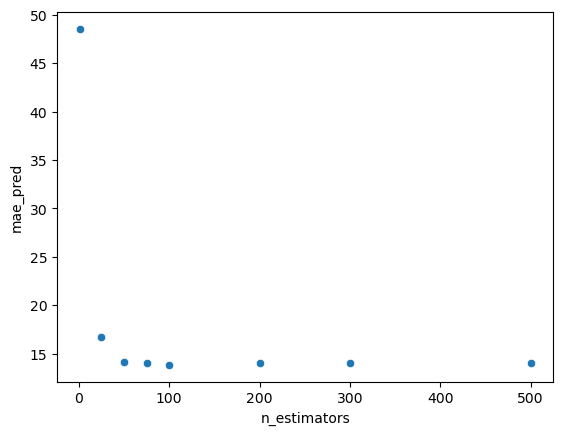

In [82]:
sns.scatterplot(x="n_estimators", y="mae_pred", data=df_res)

In [84]:
df_res.to_csv("GB_scans/Tm_n_estimators.csv")

In [86]:
df_res.sort_values(by=["mae_pred"])

,top_n_features,n_estimators,min_samp,max_depth,mae_pred,rmse_pred,r2_pred,mae_train,rmse_train,r2_train
1,30,100,20,5,13.853813,26.465113,0.854517,5.265951,9.337967,0.981888
2,30,75,20,5,13.990541,26.399688,0.855236,5.711104,10.046610,0.979035
2,30,75,20,5,13.990541,26.399688,0.855236,5.711104,10.046610,0.979035
2,30,500,20,5,14.041059,27.361778,0.844492,3.425185,7.231520,0.989138
1,30,300,20,5,14.052109,27.148249,0.846910,3.918869,7.532309,0.988215
0,30,200,20,5,14.070015,27.074050,0.847746,4.396237,7.996865,0.986717
1,30,50,20,5,14.096144,26.031016,0.859251,6.516968,11.222573,0.973839
1,30,50,20,5,14.096144,26.031016,0.859251,6.516968,11.222573,0.973839
0,30,25,20,5,16.722748,26.692841,0.852003,10.490265,15.307353,0.951330
0,30,25,20,5,16.722748,26.692841,0.852003,10.490265,15.307353,0.951330
